# Stock Prediction using Random Forest and AdaBoost model

In this notebook, we're going to train Random Forest model and AdaBoost model to do **daily stock return prediction**. In this project, We will download Apple stock prices data from Yahoo Finance and subsequently use Pandas to create lagged returns data for our training. We will then train our model using previous day of lagged returns data, given today's returns data as our target. 

**The project outline is as follows:** 
1. Download asset prices data and create lagged asset returns series
2. Train our ensemble models 
3. Estimate mean squared error for each model

### Import resources and download data from Yahoo Finance

In [147]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import datetime
import matplotlib.pyplot as plt 
import sklearn
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [148]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2020,12,31)

In [149]:
Apple = data.DataReader("AAPL", 'yahoo', start, end)

In [150]:
Apple.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,28.282499,27.552500,28.205000,27.594999,165613600.0,25.057606
2015-01-02,27.860001,26.837500,27.847500,27.332500,212818400.0,24.819241
2015-01-05,27.162500,26.352501,27.072500,26.562500,257142000.0,24.120045
2015-01-06,26.857500,26.157499,26.635000,26.565001,263188400.0,24.122320
2015-01-07,27.049999,26.674999,26.799999,26.937500,160423600.0,24.460564


In [151]:
Apple.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.549637
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.254608
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.440399
2020-12-30,135.990005,133.399994,135.580002,133.720001,96452100.0,133.294067
2020-12-31,134.740005,131.720001,134.080002,132.690002,99116600.0,132.267349


In [152]:
# create pandas DataFrame that stores the percentage returns of the adjusted closing value
AppleRet = pd.DataFrame(index=Apple.index)
AppleRet["Return"] = Apple["Adj Close"].pct_change()*100
AppleRet.dropna()

,Return
Date,
2015-01-02,-0.951269
2015-01-05,-2.817153
2015-01-06,0.009434
2015-01-07,1.402201
2015-01-08,3.842244
...,...
2020-12-24,0.771222
2020-12-28,3.576575
2020-12-29,-1.331484


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   1.,   3.,   2.,   1.,   1.,   1.,   3.,   1.,   3.,
          6.,   5.,   3.,   2.,   4.,  10.,  13.,  13.,  23.,  19.,  27.,
         24.,  36.,  32.,  56.,  72., 107., 128., 139., 105., 102., 114.,
         89.,  69.,  64.,  43.,  38.,  24.,  21.,  16.,  18.,   8.,  11.,
         11.,   7.,   5.,   3.,   3.,   2.,   3.,   1.,   2.,   1.,   1.,
          2.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-12.86469598, -12.61624086, -12.36778573, -12.11933061,
        -11.87087549, -11.62242036, -11.37396524, -11.12551011,
        -10.87705499, -10.62859986, -10.38014474, -10.13168961,
         -9.88323449,  -9.63477936,  -9.38632424,  -9.13786911,
         -8.88941399,  -8.64095887,  -8.39250374,  -8.14404862

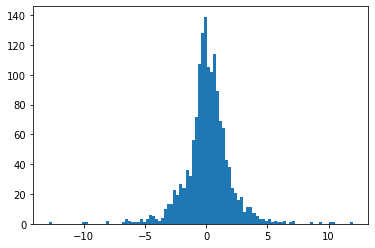

In [153]:
# check that returns data is normally distributed  
fig, ax = plt.subplots()
ax.hist(AppleRet["Return"], 100)

In [154]:
# create the shifted returns data lag series using 1 to 6 days previous close values 
AppleRet["LagReturn1"] = Apple["Adj Close"].shift(1).pct_change()*100
AppleRet["LagReturn2"] = Apple["Adj Close"].shift(2).pct_change()*100
AppleRet["LagReturn3"] = Apple["Adj Close"].shift(3).pct_change()*100
AppleRet["LagReturn4"] = Apple["Adj Close"].shift(4).pct_change()*100
AppleRet["LagReturn5"] = Apple["Adj Close"].shift(5).pct_change()*100
AppleRet["LagReturn6"] = Apple["Adj Close"].shift(6).pct_change()*100

AppleRet=AppleRet.dropna()
AppleRet

,Return,LagReturn1,LagReturn2,LagReturn3,LagReturn4,LagReturn5,LagReturn6
Date,,,,,,,
2015-01-12,-2.464062,0.107230,3.842244,1.402201,0.009434,-2.817153,-0.951269
2015-01-13,0.887863,-2.464062,0.107230,3.842244,1.402201,0.009434,-2.817153
2015-01-14,-0.381031,0.887863,-2.464062,0.107230,3.842244,1.402201,0.009434
2015-01-15,-2.714072,-0.381031,0.887863,-2.464062,0.107230,3.842244,1.402201
2015-01-16,-0.777005,-2.714072,-0.381031,0.887863,-2.464062,0.107230,3.842244
...,...,...,...,...,...,...,...
2020-12-24,0.771222,-0.697603,2.846454,1.239529,-1.585075,0.696343,-0.054734
2020-12-28,3.576575,0.771222,-0.697603,2.846454,1.239529,-1.585075,0.696343
2020-12-29,-1.331484,3.576575,0.771222,-0.697603,2.846454,1.239529,-1.585075


In [155]:
# scale the data between -1 and +1 
x = scale(AppleRet[["LagReturn1","LagReturn2", "LagReturn3", "LagReturn4", "LagReturn5", "LagReturn6" ]])
y = scale(AppleRet["Return"])

In [156]:
print("Lag return data:",x)
print("Current return data:",y)

Lag return data: [[-0.01093579  1.98797168  0.68008608 -0.06475533 -1.57800962 -0.57808748]
 [-1.38986912 -0.01259332  1.98709849  0.68212692 -0.06342665 -1.5778466 ]
 [ 0.40770205 -1.38984031 -0.01356691  1.99061878  0.68286637 -0.06333342]
 ...
 [ 1.84960553  0.34305673 -0.44467705  1.45661874  0.59570113 -0.91768696]
 [-0.7824903   1.84567269  0.34210099 -0.44390936  1.45674718  0.59576399]
 [-0.52571103 -0.78320427  1.84479235  0.34375926 -0.44228156  1.45677037]]
Current return data: [-1.38944954  0.40798334 -0.27244708 ... -0.78211745 -0.52535793
 -0.48116985]


In [157]:
# split the training set and test set, with 70% of data in the training data and the remaining 30% as the testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [158]:
print("checking shape for x_train:",x_train.shape, "\n checking shape for y_train:", y_train.shape, 
      "\n checking shape for x_test:", x_test.shape, "\n checking shape for y_test:", y_test.shape)

checking shape for x_train: (1053, 6) 
 checking shape for y_train: (1053,) 
 checking shape for x_test: (452, 6) 
 checking shape for y_test: (452,)


## Train the ensemble models 

In [159]:
# specify number of iterations/epochs, and define MSE array for each method 
epochs = 300
estimators = np.zeros(epochs+1)
rforest_mse = np.zeros(epochs+1)
boosting_mse = np.zeros(epochs+1)

In [160]:
for i in range (1, epochs+1):
    if i % 30 == 0:
        print("Random Forest model running epoch %d of %d" %(i, epochs))
    
    # define the Random Forest model
    # n_jobs is the parallelisation factor for Random Forest, n_estimators is the number of trees in the foreset    
    rforest = RandomForestRegressor(n_estimators=10*i, n_jobs=1)
    
    # fit training data to the model 
    rforest.fit(x_train, y_train)
    
    # calculate the mean squared error on the test data
    mse = mean_squared_error(y_test,rforest.predict(x_test))
    rforest_mse[i] = mse
    estimators[i] = 10*i
    

Random Forest model running epoch 30 of 300
Random Forest model running epoch 60 of 300
Random Forest model running epoch 90 of 300
Random Forest model running epoch 120 of 300
Random Forest model running epoch 150 of 300
Random Forest model running epoch 180 of 300
Random Forest model running epoch 210 of 300
Random Forest model running epoch 240 of 300
Random Forest model running epoch 270 of 300
Random Forest model running epoch 300 of 300


In [171]:
for i in range (1, epochs+1):
    if i % 10 == 0:
        print("AdaBoost model running epoch %d of %d" %(i, epochs))
        
    # define the AdaBoost model
    # adjust the learning rate for mse optimization
    AdaBoost = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=10*i, learning_rate=0.001)
    
    # fit training data to the model
    AdaBoost.fit(x_train, y_train)
    
    # calculate the mean squared error on the test data 
    mse = mean_squared_error(y_test,AdaBoost.predict(x_test))
    boosting_mse[i] = mse
    estimators[i] = 10*i
    

AdaBoost model running epoch 10 of 300
AdaBoost model running epoch 20 of 300
AdaBoost model running epoch 30 of 300
AdaBoost model running epoch 40 of 300
AdaBoost model running epoch 50 of 300
AdaBoost model running epoch 60 of 300
AdaBoost model running epoch 70 of 300
AdaBoost model running epoch 80 of 300
AdaBoost model running epoch 90 of 300
AdaBoost model running epoch 100 of 300
AdaBoost model running epoch 110 of 300
AdaBoost model running epoch 120 of 300
AdaBoost model running epoch 130 of 300
AdaBoost model running epoch 140 of 300
AdaBoost model running epoch 150 of 300
AdaBoost model running epoch 160 of 300
AdaBoost model running epoch 170 of 300
AdaBoost model running epoch 180 of 300
AdaBoost model running epoch 190 of 300
AdaBoost model running epoch 200 of 300
AdaBoost model running epoch 210 of 300
AdaBoost model running epoch 220 of 300
AdaBoost model running epoch 230 of 300
AdaBoost model running epoch 240 of 300
AdaBoost model running epoch 250 of 300
AdaBoost 

## Mean Squared Error for each method

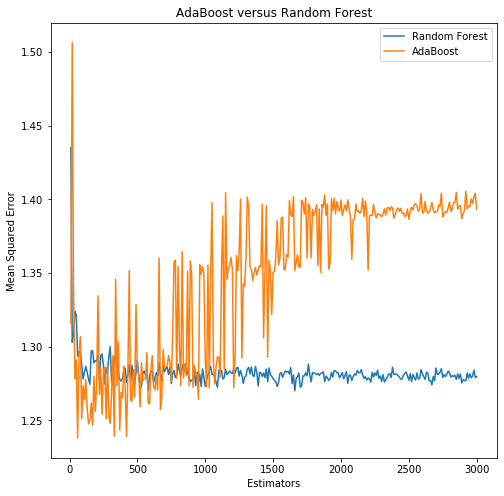

In [172]:
# plot how increasing the number of estimators/trees leads to the decreasing of MSE  
plt.figure(figsize=(8,8))
plt.plot(estimators[1:], rforest_mse[1:], label='Random Forest')
plt.plot(estimators[1:], boosting_mse[1:], label='AdaBoost')
plt.title("AdaBoost versus Random Forest")
plt.xlabel("Estimators")
plt.ylabel("Mean Squared Error")
plt.legend(loc='upper right')
plt.show()

**Evaluation & Conclusion:** Based on the MSE plot above, it can be seen that both Random Forests and AdaBoost algorithm have a decreasing MSE as we increase the estimators/trees. However, both models quickly reached to a minimum MSE value and begin fluctuating between 1.30 and 1.40 for AdaBoost, similarly at 1.28 for Random Forests. To improve the performance of the model, we might want to include other factors such as economic and fundamental elements in our daily stock returns prediction instead of just relying on previous day lagged series in our stock return analysis.   